In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing, metrics, model_selection

In [ ]:
USE_GPU = True

dtype = torch.float

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [ ]:
train_mean = 0.0
train_std = 0.0

In [ ]:
# load images
from os import listdir, path

images_list = listdir('/content/drive/MyDrive/SC201_Final_Project/images/map')

print(images_list)

image_dic_index = {}
image_dic_latlng = {}
for i in range(len(images_list)):
  image_dic_index[i] = images_list[i][:len(images_list[i])-4]
  image_dic_latlng[images_list[i][:len(images_list[i])-4]] = i
print(image_dic_index)
print(image_dic_latlng)

['25.08543_121.46053.png', '25.13007_121.46284.png', '25.18296_121.41956.png', '24.94744_121.37932.png', '25.18303_121.41955.png', '25.18134_121.42035.png', '25.08449_121.46233.png', '25.00667_121.51038.png', '25.00512_121.51365.png', '24.93428_121.37117.png', '24.98202_121.45743.png', '25.07648_121.37312.png', '25.00866_121.50909.png', '25.08976_121.44749.png', '24.94788_121.38104.png', '24.94596_121.37944.png', '24.99968_121.50347.png', '25.0456_121.45304.png', '25.02812_121.47324.png', '24.9463171_121.3757444.png', '24.996_121.46272.png', '25.08451_121.47165.png', '25.07335_121.66225.png', '25.05506_121.43284.png', '25.00017_121.43251.png', '25.00438_121.43444.png', '25.0585_121.45132.png', '25.06932_121.37732.png', '25.07373_121.36956.png', '25.07519_121.38246.png', '25.00365_121.43383.png', '24.94653_121.38176.png', '25.00563_121.51381.png', '24.9539_121.35318.png', '25.06322_121.65398.png', '25.00344_121.51772.png', '25.0077968_121.4929135.png', '25.06285_121.65468.png', '25.0723

In [ ]:
nan_cache = {}
def data_preprocess(filename,mode='Train'):
  data = pd.read_csv(filename)
  data.insert(len(data.columns), 'index', '')
  data.loc[data['lat_lng'] == '25_121.50227','lat_lng'] = '25.0_121.50227'
  index_list = []
  for index, row in data.iterrows():
    index_list.append(image_dic_latlng[row[2]])
  data['index'] = index_list
  if mode == 'Train':
    # split data to train, validation and test datsets
    train_data, val_data = model_selection.train_test_split(data,test_size = 0.2)
    means = train_data.mean()
    train_data = train_data.fillna(means)
    val_data = val_data.fillna(means)
    for column in data:
      nan_cache[column] = means
    train_y = train_data.pop('unit_price')
    val_y = val_data.pop('unit_price')
    return train_data, val_data, train_y, val_y
  elif mode == 'Test':
    real_test_data = data.fillna(nan_cache)
    return real_test_data

In [ ]:
FILE = '/content/drive/MyDrive/SC201_Final_Project/Data/final_data_0830.csv'  # Your file path

In [ ]:
train_data, val_data, train_y, val_y = data_preprocess(FILE,mode='Train')
print(val_data.shape)


(5536, 91)


In [ ]:
train_mean = 154170.694
train_std = 79570.40139
to_drop = ['zoning', 'lat','lng','lat_lng','unit_berth_price','compartmented','management_committee','floors_area','establishment','clothing_store','home_goods_store','store','local_government_office','university','natural_feature','health','tourist_attraction','transit_station','food']
for drop_items in to_drop:
  train_data.pop(drop_items)
  val_data.pop(drop_items)
  
print(train_data.columns)
print(val_data.shape)

Index(['total_floors', 'room', 'hall', 'bathroom', 'total_berth_price',
       'main_building_area', 'auxiliary_building_area', 'balcony_area',
       'elevator', 'building_age', 'travel_agency', 'point_of_interest',
       'transaction_first_floor', 'shifting_level', 'villages_towns_Sanxia',
       'villages_towns_Sanzhi', 'villages_towns_Sanchong',
       'villages_towns_Zhonghe', 'villages_towns_Zhongshan',
       'villages_towns_Zhongzheng', 'villages_towns_Wugu',
       'villages_towns_Xinyi', 'villages_towns_Neihu', 'villages_towns_Bali',
       'villages_towns_Beitou', 'villages_towns_Nangang',
       'villages_towns_Tucheng', 'villages_towns_Shilin',
       'villages_towns_Datong', 'villages_towns_Daan',
       'villages_towns_Wenshan', 'villages_towns_Xindian',
       'villages_towns_Xinzhuang', 'villages_towns_Songshan',
       'villages_towns_Banqiao', 'villages_towns_Linkou',
       'villages_towns_Shulin', 'villages_towns_Yonghe',
       'villages_towns_Xizhi', 'villages_t

In [ ]:
# load images to dictionary
def load_imgs(lat_lng):
  image = Image.open('/content/drive/MyDrive/SC201_Final_Project/images/map/{}.png'.format(lat_lng)).convert('RGB')
  image = T.ToTensor()(image)
  return image

In [ ]:
class HousingDataset(torch.utils.data.Dataset):
  def __init__(self,dataset,labels):
    self.y_train = torch.tensor(labels.values,dtype=torch.float32).view(len(labels),1)
    self.x_train = torch.tensor(dataset.values,dtype=torch.float32)
    print("HousingDataset shape {}, {}".format(self.x_train.shape, self.y_train.shape))
  def __len__(self):
    return len(self.y_train)
  def __getitem__(self,idx):
    index = int(self.x_train[idx][71])
    x_img = load_imgs(image_dic_index[index])
    return self.x_train[idx], x_img , self.y_train[idx]

In [ ]:
# Datasets load training examples one at a time, so we wrap each Dataset in a 
# DataLoader which iterates through the Dataset and forms minibatches. We divide
# the training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
# This is for after map data is loaded into the features, so shuffling is done
BATCH_SIZE = 32
def form_minibatch(data,mode='Train'):
  if mode == 'Train':
    data = DataLoader(data,batch_size=BATCH_SIZE,shuffle=True)
  elif mode == 'Test':
    data = DataLoader(data,batch_size=BATCH_SIZE)
  return data

train_dl = form_minibatch(HousingDataset(train_data,train_y))
eval_dl = form_minibatch(HousingDataset(val_data,val_y),mode='Test')
print("training size {}, eval size {}".format(len(train_dl), len(eval_dl)))

HousingDataset shape torch.Size([22140, 72]), torch.Size([22140, 1])
HousingDataset shape torch.Size([5536, 72]), torch.Size([5536, 1])
training size 692, eval size 173


In [ ]:
# model = MyModel()
class MyModel(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.nn = nn.Sequential(
        nn.Linear(input_size, 60),
        nn.BatchNorm1d(60),
        nn.ReLU(),
        nn.Linear(60, 30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(30, 15),
        nn.BatchNorm1d(15),
        nn.ReLU(),
        nn.Linear(15, 8),
        nn.BatchNorm1d(8),
        )
        # epoch 25-29
        resnet = torchvision.models.resnet50(pretrained=True)
        for param in resnet.parameters():
          param.requires_grad = False
        

        self.features2 = nn.Sequential(
              nn.AdaptiveAvgPool2d((224,224)),
              *list(resnet.children())[:6],

              # N x 512 * 28 * 28
              nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
              nn.BatchNorm2d(256),
              nn.ReLU(),

              # N x 256 * 28 * 28
              nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              # N x 128 * 28 * 28
              nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(),

              # N x 64 x 28 x 28  
              nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(),

              nn.MaxPool2d(kernel_size=2, stride=2),  

              # N x 32 x 14 x 14
              nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
              nn.BatchNorm2d(16),
              nn.ReLU(),

              # N x 16 x 14 x 14
              nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
              nn.BatchNorm2d(8),
              nn.ReLU(),

              nn.MaxPool2d(kernel_size=2, stride=2),

              # N x 8 x 7 x 7
              
              nn.Flatten(),
              nn.Linear(8*7*7,16)
          )
        self.metrics = 0
        self.fc_out = nn.Sequential(
            nn.Linear(24,16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Linear(4,1)
        )


    def forward(self,x1,x2):
        x1 = self.nn(x1)
        x1 = x1.view(x1.size(0), -1)
        x1 = F.relu(x1)

        x2 = self.features2(x2)
        x2 = x2.view(x2.size(0), -1)
        x2 = F.relu(x2)
        # Concatenate in dim1 (feature dimension)
        x = torch.cat((x1, x2),1)
        scores = self.fc_out(x)
        return scores

net = MyModel(71)
optimizer = torch.optim.Adam(net.parameters(),lr=5e-4,weight_decay=0.99)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
optimizer_SGD_momentum = torch.optim.SGD(net.parameters(),lr=1e-5,momentum=0.9,weight_decay=0.98)

In [ ]:
loss_history=[]
val_loss=[]
def train(data1, data2, model, optimizer, epochs=1):
    """
    Train a model on real estate data property features 
    and extracte map features using the PyTorch Module API.
    
    Inputs:
    - data1: training data
    - data2: validation data
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    criterion = nn.L1Loss()
    for e in range(epochs):
        running_loss = 0.0
        for t, (x,x2,y) in enumerate(data1):
            model.train()  # put model to training mode
            indices = torch.tensor(range(0, 71))    # how to drop column from tensor
            x1 = torch.index_select(x, 1, indices)
            x1 = x1.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x2 = x2.to(device=device,dtype=dtype)
            y = y.to(device=device, dtype=dtype)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()
            
            scores = model(x1,x2)
            loss = criterion(scores,y)
            running_loss += loss.item()
            loss_history.append(loss)

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            training_loss = running_loss/len(data1)
            if t % 100 == 0:
                running_loss = 0.0
                print('Iteration %d, loss = %.4f' % (t, training_loss))
                print('Checking accuracy on validation set')
                eval_loss, eval_l1_loss = check_accuracy(data2, model)
                print("Epoch {}, Eval loss: {}, l1 loss: {}".format(e, eval_loss, eval_l1_loss))
        lr_scheduler.step(model.metrics)


In [ ]:
def check_accuracy(data, model):
    criterion = nn.L1Loss() 
    total_loss = 0.0
    total_l1_loss = 0.0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
      for x,x2,y in data:
        indices = torch.tensor(range(0, 71))
        x1 = torch.index_select(x, 1, indices)
        x1 = x1.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        x2 = x2.to(device=device,dtype=dtype)
        y = y.to(device=device, dtype=dtype)
        scores = model(x1,x2)
        loss = criterion(scores,y)
        total_loss += loss.item()
        ground_truth_price = y * train_std + train_mean
        predicted_price = scores * train_std + train_mean
        total_l1_loss += abs(ground_truth_price - predicted_price)
      val_loss.append(total_l1_loss.data[0][0]/len(data))
      return total_loss/len(data), total_l1_loss.data[0][0]/len(data)

In [ ]:
train(train_dl, eval_dl, net,optimizer,epochs=5)

Iteration 0, loss = 0.0013
Checking accuracy on validation set
Epoch 0, Eval loss: 0.7342327588555441, l1 loss: 65739.78125
Iteration 100, loss = 0.0911
Checking accuracy on validation set
Epoch 0, Eval loss: 0.5554849150552915, l1 loss: 47869.37890625
Iteration 200, loss = 0.0667
Checking accuracy on validation set
Epoch 0, Eval loss: 0.5498108031777288, l1 loss: 47287.44921875
Iteration 300, loss = 0.0632
Checking accuracy on validation set
Epoch 0, Eval loss: 0.5317540382374228, l1 loss: 47511.734375
Iteration 400, loss = 0.0559
Checking accuracy on validation set
Epoch 0, Eval loss: 0.4741119341009614, l1 loss: 42440.6796875
Iteration 500, loss = 0.0608
Checking accuracy on validation set
Epoch 0, Eval loss: 0.538304546664905, l1 loss: 48716.7734375
Iteration 600, loss = 0.0614
Checking accuracy on validation set
Epoch 0, Eval loss: 0.5247054360160938, l1 loss: 47372.72265625
Iteration 0, loss = 0.0005
Checking accuracy on validation set
Epoch 1, Eval loss: 0.4799613101633987, l1 l

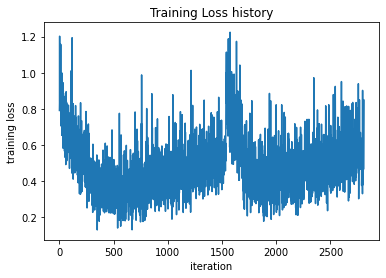

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_history)),loss_history)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

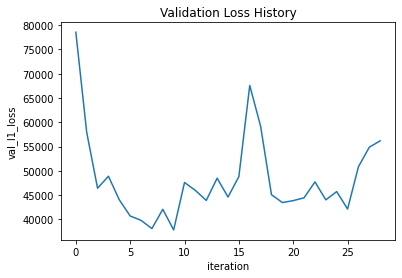

In [ ]:
plt.plot(range(len(val_loss)),val_loss)
plt.xlabel('iteration')
plt.ylabel('val_l1_loss')
plt.title('Validation Loss History')
plt.show()